In [1]:
%matplotlib inline

import sys
import numpy as np
from numpy import linalg
import pandas as pd
import scipy as sp
from scipy import cluster
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import math
import pickle
import pystan as ps
import importlib
import src.ITCC as itcc
import src.stan_utility as su
import src.draw as draw

In [2]:
import os

_DATA_DIRECTORY = 'data/'

def full_path(path):
    return os.path.join(_DATA_DIRECTORY, path)

In [3]:
# Some utility functions

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Data Mettle Blue',
    [(0.28205128, 0.87179487, 1.0), (0.09401709, 0.29059829, 0.33333333)]
)

def getbins(x, n):
    return min(x) + np.linspace(0, 1, n) * (max(x) - min(x))

def hist(x, n, alpha=1.0, color=None):
    plt.hist(x, bins=getbins(x, n), alpha=alpha, color=color)

def heatmap(data, row_clusters, column_clusters, title=""):
    fit_data = data.values[np.argsort(row_clusters)]
    fit_data = fit_data[:, np.argsort(column_clusters)]
    
    plt.matshow(fit_data, cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

def write_pickle(d, path):
    with open(path, 'wb') as file:
        pickle.dump(d, file)

def read_pickle(path):
    with open(path, 'rb') as file:
        return pickle.load(file)

In [4]:
eurovision = pd.read_csv(full_path('eurovision_all.csv'))
eurovision.head()

,Year,Stage,Jury or Televoting,From country,To country,Points
0,1975,f,J,Belgium,Belgium,0
1,1975,f,J,Belgium,Finland,0
2,1975,f,J,Belgium,France,2
3,1975,f,J,Belgium,Germany,0
4,1975,f,J,Belgium,Ireland,12


Let $r_{c_ic_jy_k}$ denote the fraction of people in country $c_i$ that voted for country $c_j$ in the year $y_k$. Note that
$\sum_{j=1}^Nr_{c_ic_jy_k} = 1$, so we model the vector
$\mathbf{r}_{c_iy_k} = (r_{c_ic_1y_k}, \dots, r_{c_ic_Ny_k})$ as following a
[Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution)

$$\mathbf{r}_{c_iy_k} \sim \operatorname{Dir}(B_{c_iy_k})$$.

We choose a model where the parameters

$$B_{c_iy_k} = (\beta_{c_ic_1y_k}, \dots, \beta_{c_ic_Ny_k})$$

decompose as

$$\beta_{c_ic_jy_k} = \operatorname{Exp}\bigl(\theta_{c_iy_j} + \phi_{c_ic_j}\bigr),$$

where $\theta_{c_iy_j}$ captures the objective quality of the song from country $c_i$ in the year $y_k$, and $\phi_{c_ic_j}$ captures the bias country $c_i$ has in voting (or not voting) for country $c_j$. Furthermore, we assume that $\theta$ and $\phi$ are drawn from an (unknown) normal distribution:

$$
    \theta_{c_iy_j}\sim N(\mu, \sigma),
$$
$$
    \phi_{c_ic_j}\sim N(\mu, \sigma).
$$

Note that we don't actually have access to $r_{c_ic_jy_k}$, we only have data on the number of points each country was awarded. But we make do with what we have and approximate $r_{c_ic_jy_k}$ by

$$
    r_{c_ic_jy_k}
    \simeq
    \frac{\text{(points awarded to country $c_j$ by country $c_i$ in the year $y_k$}) + \alpha}{(\text{total points awarded by country $c_i$ in the year $y_k$}) + N\alpha},
$$

where $\alpha$ is a constant that we set to 0.1.

It's hard to say for definite whether this is a reasonable approximation without being able to actually see the voting data, but preferences often follow [power laws](https://en.wikipedia.org/wiki/Power_law), and the decreasing sequence of points 12, 10, 8, 6, 4, 2, 1, 0, 0, 0, ... at least follow a similar shape (see below for an example with 15 countries). Note that we do completely miss out on any information about the tail, but we assume that this is mostly noise that don't contribute much anyway.

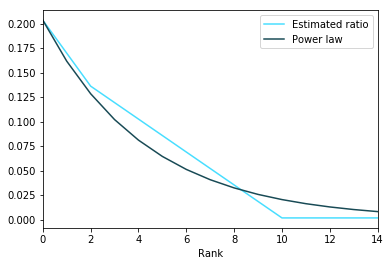

In [5]:
nr_countries = 15
alpha = 0.1
df = pd.DataFrame({'Rank': range(nr_countries), 'Score': ([12, 10, 8, 7, 6, 5, 4, 3, 2, 1] + [0]*(nr_countries-10))})
df['Estimated ratio'] = df['Score'].apply(lambda score: (score + 0.1) / (df['Score'].sum() + nr_countries*alpha))
max_ratio = df['Estimated ratio'].max()
df['Power law'] = df['Rank'].apply(lambda rank: max_ratio * math.exp(-0.23 * rank))

plt = df.set_index('Rank')[['Estimated ratio', 'Power law']].plot(cmap=cmap)
plt.get_figure().savefig('images/powerlaw.png', bbox_inches='tight', dpi=150)

In [10]:
model_code = """
    data {
        int<lower=1> nr_countries;
        int<lower=1> nr_years;
        int<lower=1> nr_datapoints;
        int<lower=1> nr_slices;
        int<lower=1> max_slice_size;
        int<lower=1> slice_sizes[nr_slices];
        int<lower=1> slice_from_country[nr_slices];
        int<lower=1> slice_years[nr_slices];
        int<lower=1> to_country_index[nr_datapoints];
        vector<lower=0, upper=1>[nr_datapoints] y;
    }
    
    parameters {
        real mu;
        real<lower=1.0e-12> sigma;
        real<lower=-2> theta[nr_countries, nr_years];
        real<lower=-2> phi[nr_countries, nr_countries];
    }

    model {
        int pos;
        int slice_size;
        int from_country;
        int year;
        vector[max_slice_size] beta;
        
        for (k in 1:nr_countries) {
            for (l in 1:nr_years) {
                theta[k][l] ~ normal(mu, sigma);
            }
            for (l in 1:nr_countries) {
                phi[k][l] ~ normal(mu, sigma);
            }
        }
        
        pos = 1;
        for (s in 1:nr_slices) {
            slice_size = slice_sizes[s];
            from_country = slice_from_country[s];
            year = slice_years[s];

            // Build the Dirichlet parameters
            for (n in 1:slice_size) {
                beta[n] = exp(theta[to_country_index[pos + n - 1]][year] + phi[from_country][to_country_index[pos + n - 1]]);
            }
            
            segment(y, pos, slice_size) ~ dirichlet(segment(beta, 1, slice_size));
            
            pos = pos + slice_size;
        }
    }
    
    generated quantities {
        vector[nr_countries] beta_p;
        vector[nr_countries] b[nr_countries];
        real beta_sum;
        for (i in 1:nr_countries) {
            // Build beta for Dirichlet
            beta_sum = 0;
            for (j in 1:nr_countries) {
                if (j == i) {
                    beta_p[j] = 0.0;
                } else {
                    beta_p[j] = exp(mu + phi[i][j]);
                }
                beta_sum += beta_p[j];
            }
            for (j in 1:nr_countries) {
                b[i][j] = beta_p[j] / beta_sum;
            }
        }
    }
"""

ps_model = ps.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4d36956bbcc42979b8e8c26f5da44223 NOW.


In [11]:
def prepare_data(df, alpha, mask):
    """
    df: A 'eurovision' dataframe.
    alpha: 
    mask: A predicate which filters the dataframe to the relevant rows.
    
    Returns: Same as the filtered df, but with a new 'Score' column.
    """
    data = (
        df[mask(df)]
        .assign(YearStage=lambda _: _['Year'].map(str) + _['Stage'])
    )

    points_by_stage = (
        data[['Year', 'Stage', 'From country', 'Points']]
        .groupby(['Year', 'Stage', 'From country'])
        .agg(sum)
        .reset_index()[['Year', 'Stage', 'Points']]
        .groupby(['Year', 'Stage'])
        .agg(max)
        .reset_index()
        .rename(columns={'Points': 'Total points'})
    )

    countries_by_stage = (
        data[['Year', 'Stage', 'From country']]
        .groupby(['Year', 'Stage', 'From country'])
        .agg(len)
        .reset_index()
        .rename(columns={0: 'Nr countries'})
    )

    data = pd.merge(data, points_by_stage)
    data = pd.merge(data, countries_by_stage)
    data['Score'] = (data['Points'] + alpha) / (data['Total points'] + alpha*data['Nr countries'])
    
    return data

In [12]:
def make_stan_dict(data):
    """
    Returns a dictionary suitable to be passed into PyStan.
    """
    countries = np.array(list(set(data['From country']).union(set(data['To country']))))
    countries_map = dict([(country, index) for index, country in enumerate(countries)])
    from_country_index = [countries_map[country] for country in data['From country']]
    to_country_index = [countries_map[country] for country in data['To country']]
    nr_countries = len(countries)
    years = data['Year'].unique()
    years_map = dict([year, index] for index, year in enumerate(years))
    year_index = [years_map[year] for year in data['Year']]
    nr_years = len(years)
    stages = data['YearStage'].unique()
    nr_stages = len(stages)

    y = []
    slice_sizes = []
    slice_from_country = []
    slice_years = []
    to_country_index = []

    for stage_i, stage in enumerate(stages):
        stage_data = data[data['YearStage'] == stage]
        year = stage_data['Year'].unique()[0]
        for from_country in stage_data['From country'].unique():
            slice_from_country.append(countries_map[from_country])
            slice_years.append(years_map[year])
            from_country_data = stage_data[stage_data['From country'] == from_country]
            slice_size = from_country_data.shape[0]
            slice_sizes.append(slice_size)
            for index, row in from_country_data.iterrows():
                y.append(row['Score'])
                to_country_index.append(countries_map[row['To country']])
    
    stan_dict = {
        'nr_countries': nr_countries,
        'nr_years': nr_years,
        'nr_datapoints': len(y),
        'nr_slices': len(slice_sizes),
        'max_slice_size': max(slice_sizes),
        'slice_sizes': slice_sizes,
        'slice_from_country': np.array(slice_from_country) + 1,
        'slice_years': np.array(slice_years) + 1,
        'to_country_index': np.array(to_country_index) + 1,
        'y': y
    }
    
    return countries, countries_map, years, years_map, stan_dict

In [13]:
# Run the PyStan sampler

data = prepare_data(eurovision,
                    alpha=0.1,
                    mask=lambda _: (_['Year'] >= 2010) & (_['Year'] <= 2015) & (_['Jury or Televoting'] == '50/50'))

countries, countries_map, years, years_map, stan_dict = make_stan_dict(data)

# This takes about 15 minutes on my machine (MacBook Pro with 2.8 GHz Intel Core i7)
fit = ps_model.sampling(data=stan_dict,
                        iter=4000,
                        chains=8,
                        control={
                            'max_treedepth': 20,
                            'adapt_delta': 0.9
                        })

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [14]:
# Extract the data from the fit
extract = fit.extract()

In [15]:
# Diagnose the fit to make sure it converged OK.
su.check_all_diagnostics(fit)

n_eff / iter looks reasonable for all parameters
Rhat for parameter beta_p[46] is nan!
  Rhat above 1.1 indicates that the chains very likely have not mixed
0.0 of 16000 iterations ended with a divergence (0.0%)
0 of 16000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior


As Stan is Bayesian we obtain *distributions* for $\theta$ and $\phi$. To get something to work with we use the mean as point estimates.

In [51]:
theta_mean = extract['theta'].mean(axis=0) - extract['theta'].mean()
# phi_mean = extract['phi'].mean(axis=0) - extract['phi'].mean()

(nr_samples, nr_countries, _) = extract['phi'].shape
p_predicted = np.zeros((nr_samples, nr_countries, nr_countries))

for i in range(nr_countries):
    for j in range(nr_countries):
        p_predicted[:, i, j] = np.exp(extract['theta'].mean() + extract['phi'][:, i, j])

p_predicted /= p_predicted.sum(axis=1)[:, None, :]
# Phi mean is the probability that country i would vote for country j
# given that you can vote for all countries, and all entries are objectively
# equally good
phi_mean = p_predicted.mean(axis=0)

In [39]:
# Let's look at the 'objective quality' for each country in 2015.

sorted([(country, theta_mean[countries_map[country], years_map[2015]])
       for country in countries],
       key=lambda _:_[1])[::-1]

[('Sweden', 1.911164238980377),
 ('Italy', 1.8510307289084955),
 ('Russia', 1.6989809903136404),
 ('Australia', 1.4643829189775044),
 ('Belgium', 1.4415792970391879),
 ('Latvia', 1.4141919601221997),
 ('Israel', 0.8293607367057587),
 ('Estonia', 0.7809883177068935),
 ('Norway', 0.7250236078200378),
 ('Georgia', 0.41284488596112523),
 ('Slovenia', 0.1782952419220592),
 ('Serbia', 0.09920813328719916),
 ('Denmark', 0.0751198280917312),
 ('Romania', 0.05303509876966095),
 ('Montenegro', 0.038888885974088266),
 ('Azerbaijan', 0.005140718544002054),
 ('Slovakia', 0.0045525472502835895),
 ('Bosnia & Herzegovina', 0.003271270401609516),
 ('Bulgaria', 0.0015462989018293904),
 ('Croatia', -0.001250003188049742),
 ('Ukraine', -0.0017931422571438316),
 ('Turkey', -0.006469512845962755),
 ('Lithuania', -0.01886694510581083),
 ('Armenia', -0.020188471788188223),
 ('Greece', -0.035312996313744904),
 ('Cyprus', -0.09044137568078114),
 ('The Netherlands', -0.1155427310060893),
 ('Ireland', -0.13298547

In [52]:
# How are the biases for/aginst Malta?

sorted([(country, phi_mean[countries_map['Malta'], countries_map[country]])
        for country in countries],
       key=lambda _:_[1])[::-1]

[('Italy', 0.049557670750722746),
 ('Azerbaijan', 0.04365571259922767),
 ('United Kingdom', 0.03553277158251567),
 ('San Marino', 0.025847008646234192),
 ('Norway', 0.025368067453259105),
 ('Australia', 0.024427114470403053),
 ('Belarus', 0.02422353142342053),
 ('Romania', 0.02411105631350743),
 ('Austria', 0.023794712073953225),
 ('Switzerland', 0.023614947110142455),
 ('Slovakia', 0.023481172964989958),
 ('Czech Republic', 0.02260153067260141),
 ('Denmark', 0.022322968466177515),
 ('France', 0.021980264627370627),
 ('Croatia', 0.021975459960617824),
 ('Greece', 0.021344264055127033),
 ('Israel', 0.020975529677993987),
 ('Sweden', 0.02054342740679022),
 ('Latvia', 0.019934647244817135),
 ('Ireland', 0.01979365575962262),
 ('Ukraine', 0.01917289457900183),
 ('Armenia', 0.01903483626238104),
 ('Germany', 0.019030680440599825),
 ('Lithuania', 0.019005735087799763),
 ('F.Y.R. Macedonia', 0.018501401298124283),
 ('Bulgaria', 0.018238653092225568),
 ('Portugal', 0.01807712339432974),
 ('Slo

In [19]:
hist(extract['phi'].flatten(), 100)

In [20]:
hist(extract['theta'].flatten(), 100)

In [40]:
# Investigate the largest biases

# Sort by bias
from_country, to_country = np.unravel_index(np.argsort(phi_mean.ravel()), phi_mean.shape)

# Reverse to get largest bias first
from_country = from_country[::-1]
to_country = to_country[::-1]
for i in range(30):
    print(f'{countries[from_country[i]]} -> {countries[to_country[i]]}: {phi_mean[from_country[i]][to_country[i]]}')

Moldova -> Romania: 1.8963292745163476
Greece -> Cyprus: 1.7627675668199991
Cyprus -> Greece: 1.6158273527171043
Romania -> Moldova: 1.606551549088611
Georgia -> Armenia: 1.5165687520872981
Armenia -> Georgia: 1.4089303788708145
Greece -> Albania: 1.4085710080995257
F.Y.R. Macedonia -> Albania: 1.3839113103574299
Moldova -> Belarus: 1.3553586667489612
Turkey -> Bosnia & Herzegovina: 1.3486956282550793
Lithuania -> Georgia: 1.3390725430931325
Belarus -> Ukraine: 1.3168238541069823
Azerbaijan -> Georgia: 1.3146659525352478
Croatia -> Bosnia & Herzegovina: 1.3077256245114124
Finland -> Estonia: 1.3020303650969893
Moldova -> Ukraine: 1.3005615661186392
Latvia -> Estonia: 1.278911462759887
United Kingdom -> Ireland: 1.2665282337249182
Ireland -> Lithuania: 1.2536219524610517
Albania -> Greece: 1.2514343715539333
Georgia -> Lithuania: 1.239510706638054
Bosnia & Herzegovina -> F.Y.R. Macedonia: 1.2389966841475308
Hungary -> Iceland: 1.2157118764676051
Russia -> Azerbaijan: 1.2144640755321683


In [22]:
for country in range(len(countries)):
    hist(extract['theta'][:, country, years_map[2015]], 100, alpha=0.7)

# Clustering

Now that we have the biases between the countries, we can try and cluster the countries to see if we can identify specific groups. A suitable clustering technique is [Information Theoretic Co-Clustering](http://www.cs.utexas.edu/users/inderjit/public_papers/kdd_cocluster.pdf), which is great for clustering weighted directed graphs. This is exactly what we have if we consider each country as a node, and the bias as a weighted directed edge.

One issue is that ITCC clusters source and target nodes separately, that is you get one clustering based on how the countries vote, and another clustering based on who they recieved votes from. This is a bit difficult to interpret, so instead we restrict the clustering to enforce that the source and target clusterings are the same. Our code is based on Mohammad Gorji Sefidmazgi's implementation, which can be found here: https://github.com/mgorjis/ITCC

In [66]:
phi_df = pd.DataFrame(data=phi_mean-phi_mean.min(), columns=countries, index=countries)

# This is a pretty basic greedy clusterer, not very efficient.
# The best clustering we've found has a KL-divergence of 6.457572495289641.
clusters = itcc.information_cocluster_restricted(phi_df, 3, 10)

Before greedy optimisation: 6.767339855603244.
Testing index 0, in cluster 2.
Testing index 1, in cluster 0.
Testing index 2, in cluster 0.
Found better cluster: 1 (6.707654461859241).
Testing index 0, in cluster 2.
Testing index 1, in cluster 0.
Testing index 2, in cluster 1.
Testing index 3, in cluster 0.
Testing index 4, in cluster 0.
Found better cluster: 1 (6.64343405054788).
Testing index 0, in cluster 2.
Testing index 1, in cluster 0.
Testing index 2, in cluster 1.
Testing index 3, in cluster 0.
Testing index 4, in cluster 1.
Testing index 5, in cluster 0.
Testing index 6, in cluster 0.
Testing index 7, in cluster 1.
Found better cluster: 0 (6.577491496063188).
Testing index 0, in cluster 2.
Testing index 1, in cluster 0.
Testing index 2, in cluster 1.
Testing index 3, in cluster 0.
Testing index 4, in cluster 1.
Testing index 5, in cluster 0.
Testing index 6, in cluster 0.
Testing index 7, in cluster 0.
Testing index 8, in cluster 2.
Testing index 9, in cluster 1.
Testing index

Testing index 5, in cluster 2.
Testing index 6, in cluster 1.
Testing index 7, in cluster 2.
Testing index 8, in cluster 0.
Testing index 9, in cluster 1.
Testing index 10, in cluster 2.
Testing index 11, in cluster 2.
Testing index 12, in cluster 2.
Testing index 13, in cluster 2.
Testing index 14, in cluster 2.
Testing index 15, in cluster 1.
Testing index 16, in cluster 1.
Testing index 17, in cluster 1.
Testing index 18, in cluster 1.
Testing index 19, in cluster 1.
Testing index 20, in cluster 0.
Testing index 21, in cluster 1.
Testing index 22, in cluster 1.
Testing index 23, in cluster 2.
Testing index 24, in cluster 2.
Testing index 25, in cluster 0.
Testing index 26, in cluster 0.
Testing index 27, in cluster 1.
Testing index 28, in cluster 0.
Testing index 29, in cluster 2.
Testing index 30, in cluster 0.
Testing index 31, in cluster 1.
Testing index 32, in cluster 0.
Testing index 33, in cluster 1.
Testing index 34, in cluster 0.
Testing index 35, in cluster 2.
Found better 

Testing index 1, in cluster 0.
Testing index 2, in cluster 1.
Testing index 3, in cluster 1.
Testing index 4, in cluster 2.
Testing index 5, in cluster 0.
Testing index 6, in cluster 1.
Testing index 7, in cluster 0.
Testing index 8, in cluster 0.
Testing index 9, in cluster 2.
Testing index 10, in cluster 0.
Testing index 11, in cluster 1.
Testing index 12, in cluster 0.
Testing index 13, in cluster 0.
Testing index 14, in cluster 0.
Testing index 15, in cluster 2.
Testing index 16, in cluster 0.
Testing index 17, in cluster 2.
Testing index 18, in cluster 0.
Testing index 19, in cluster 2.
Testing index 20, in cluster 0.
Testing index 21, in cluster 0.
Testing index 22, in cluster 2.
Found better cluster: 0 (6.929807346261697).
Testing index 0, in cluster 1.
Testing index 1, in cluster 0.
Testing index 2, in cluster 1.
Testing index 3, in cluster 1.
Testing index 4, in cluster 2.
Testing index 5, in cluster 0.
Testing index 6, in cluster 1.
Testing index 7, in cluster 0.
Testing inde

Testing index 6, in cluster 2.
Testing index 7, in cluster 1.
Testing index 8, in cluster 1.
Testing index 9, in cluster 0.
Testing index 10, in cluster 1.
Testing index 11, in cluster 1.
Testing index 12, in cluster 2.
Testing index 13, in cluster 1.
Testing index 14, in cluster 1.
Testing index 15, in cluster 0.
Testing index 16, in cluster 2.
Testing index 17, in cluster 0.
Testing index 18, in cluster 2.
Testing index 19, in cluster 0.
Testing index 20, in cluster 1.
Testing index 21, in cluster 2.
Found better cluster: 0 (6.48347480259586).
Testing index 0, in cluster 1.
Testing index 1, in cluster 2.
Testing index 2, in cluster 2.
Testing index 3, in cluster 2.
Testing index 4, in cluster 0.
Testing index 5, in cluster 2.
Testing index 6, in cluster 2.
Testing index 7, in cluster 1.
Testing index 8, in cluster 1.
Testing index 9, in cluster 0.
Testing index 10, in cluster 1.
Testing index 11, in cluster 1.
Testing index 12, in cluster 2.
Testing index 13, in cluster 1.
Testing in

Testing index 3, in cluster 0.
Testing index 4, in cluster 1.
Found better cluster: 2 (6.919440044765055).
Testing index 0, in cluster 0.
Testing index 1, in cluster 0.
Testing index 2, in cluster 0.
Testing index 3, in cluster 0.
Testing index 4, in cluster 2.
Testing index 5, in cluster 2.
Testing index 6, in cluster 0.
Testing index 7, in cluster 2.
Testing index 8, in cluster 2.
Testing index 9, in cluster 1.
Testing index 10, in cluster 0.
Testing index 11, in cluster 2.
Testing index 12, in cluster 2.
Testing index 13, in cluster 0.
Found better cluster: 2 (6.917743371967181).
Testing index 0, in cluster 0.
Testing index 1, in cluster 0.
Testing index 2, in cluster 0.
Testing index 3, in cluster 0.
Testing index 4, in cluster 2.
Testing index 5, in cluster 2.
Testing index 6, in cluster 0.
Testing index 7, in cluster 2.
Testing index 8, in cluster 2.
Testing index 9, in cluster 1.
Testing index 10, in cluster 0.
Testing index 11, in cluster 2.
Testing index 12, in cluster 2.
Test

Testing index 3, in cluster 2.
Testing index 4, in cluster 1.
Testing index 5, in cluster 2.
Testing index 6, in cluster 2.
Testing index 7, in cluster 1.
Testing index 8, in cluster 2.
Testing index 9, in cluster 0.
Testing index 10, in cluster 2.
Testing index 11, in cluster 1.
Testing index 12, in cluster 2.
Found better cluster: 1 (6.907019866145228).
Testing index 0, in cluster 1.
Testing index 1, in cluster 2.
Testing index 2, in cluster 1.
Testing index 3, in cluster 2.
Testing index 4, in cluster 1.
Testing index 5, in cluster 2.
Testing index 6, in cluster 2.
Testing index 7, in cluster 1.
Testing index 8, in cluster 2.
Testing index 9, in cluster 0.
Testing index 10, in cluster 2.
Testing index 11, in cluster 1.
Testing index 12, in cluster 1.
Testing index 13, in cluster 1.
Testing index 14, in cluster 1.
Testing index 15, in cluster 0.
Testing index 16, in cluster 2.
Testing index 17, in cluster 0.
Testing index 18, in cluster 2.
Testing index 19, in cluster 0.
Testing inde

Testing index 6, in cluster 2.
Testing index 7, in cluster 1.
Testing index 8, in cluster 2.
Testing index 9, in cluster 0.
Testing index 10, in cluster 2.
Testing index 11, in cluster 2.
Testing index 12, in cluster 2.
Testing index 13, in cluster 1.
Testing index 14, in cluster 1.
Testing index 15, in cluster 0.
Testing index 16, in cluster 2.
Testing index 17, in cluster 0.
Testing index 18, in cluster 2.
Testing index 19, in cluster 0.
Testing index 20, in cluster 2.
Testing index 21, in cluster 1.
Testing index 22, in cluster 1.
Testing index 23, in cluster 2.
Testing index 24, in cluster 0.
Testing index 25, in cluster 2.
Testing index 26, in cluster 2.
Found better cluster: 1 (6.841205387000111).
Testing index 0, in cluster 1.
Testing index 1, in cluster 2.
Testing index 2, in cluster 1.
Testing index 3, in cluster 1.
Testing index 4, in cluster 1.
Testing index 5, in cluster 2.
Testing index 6, in cluster 2.
Testing index 7, in cluster 1.
Testing index 8, in cluster 2.
Testing 

Testing index 5, in cluster 1.
Testing index 6, in cluster 2.
Testing index 7, in cluster 1.
Testing index 8, in cluster 0.
Testing index 9, in cluster 2.
Testing index 10, in cluster 1.
Testing index 11, in cluster 1.
Found better cluster: 0 (6.784670607036648).
Testing index 0, in cluster 0.
Testing index 1, in cluster 1.
Testing index 2, in cluster 2.
Testing index 3, in cluster 2.
Testing index 4, in cluster 2.
Testing index 5, in cluster 1.
Testing index 6, in cluster 2.
Testing index 7, in cluster 1.
Testing index 8, in cluster 0.
Testing index 9, in cluster 2.
Testing index 10, in cluster 1.
Testing index 11, in cluster 0.
Testing index 12, in cluster 1.
Testing index 13, in cluster 1.
Testing index 14, in cluster 1.
Testing index 15, in cluster 2.
Testing index 16, in cluster 2.
Testing index 17, in cluster 2.
Testing index 18, in cluster 2.
Testing index 19, in cluster 2.
Testing index 20, in cluster 0.
Testing index 21, in cluster 2.
Found better cluster: 1 (6.782785217114339

Testing index 22, in cluster 0.
Testing index 23, in cluster 0.
Testing index 24, in cluster 2.
Testing index 25, in cluster 0.
Testing index 26, in cluster 1.
Testing index 27, in cluster 2.
Testing index 28, in cluster 0.
Testing index 29, in cluster 0.
Testing index 30, in cluster 1.
Testing index 31, in cluster 0.
Testing index 32, in cluster 1.
Testing index 33, in cluster 0.
Found better cluster: 1 (6.8927511932761405).
Testing index 0, in cluster 0.
Testing index 1, in cluster 1.
Testing index 2, in cluster 0.
Testing index 3, in cluster 1.
Testing index 4, in cluster 0.
Testing index 5, in cluster 1.
Testing index 6, in cluster 1.
Testing index 7, in cluster 0.
Found better cluster: 1 (6.890678163408777).
Testing index 0, in cluster 0.
Testing index 1, in cluster 1.
Testing index 2, in cluster 0.
Testing index 3, in cluster 1.
Testing index 4, in cluster 0.
Testing index 5, in cluster 1.
Testing index 6, in cluster 1.
Testing index 7, in cluster 1.
Testing index 8, in cluster 1

Testing index 36, in cluster 0.
Testing index 37, in cluster 1.
Testing index 38, in cluster 0.
Testing index 39, in cluster 1.
Testing index 40, in cluster 1.
Testing index 41, in cluster 2.
Testing index 42, in cluster 1.
Testing index 43, in cluster 1.
Testing index 44, in cluster 0.
Testing index 45, in cluster 2.
Found better cluster: 0 (6.77997044724404).
Testing index 0, in cluster 0.
Testing index 1, in cluster 1.
Testing index 2, in cluster 0.
Testing index 3, in cluster 0.
Testing index 4, in cluster 0.
Testing index 5, in cluster 1.
Testing index 6, in cluster 1.
Testing index 7, in cluster 0.
Testing index 8, in cluster 1.
Testing index 9, in cluster 2.
Testing index 10, in cluster 1.
Testing index 11, in cluster 1.
Testing index 12, in cluster 1.
Testing index 13, in cluster 0.
Testing index 14, in cluster 0.
Testing index 15, in cluster 2.
Testing index 16, in cluster 1.
Testing index 17, in cluster 2.
Testing index 18, in cluster 1.
Testing index 19, in cluster 2.
Testin

Testing index 2, in cluster 0.
Testing index 3, in cluster 1.
Testing index 4, in cluster 0.
Testing index 5, in cluster 1.
Testing index 6, in cluster 1.
Testing index 7, in cluster 2.
Testing index 8, in cluster 2.
Testing index 9, in cluster 0.
Testing index 10, in cluster 2.
Testing index 11, in cluster 2.
Testing index 12, in cluster 1.
Testing index 13, in cluster 2.
Testing index 14, in cluster 2.
Testing index 15, in cluster 0.
Testing index 16, in cluster 1.
Testing index 17, in cluster 0.
Testing index 18, in cluster 1.
Testing index 19, in cluster 0.
Testing index 20, in cluster 2.
Testing index 21, in cluster 0.
Testing index 22, in cluster 0.
Testing index 23, in cluster 2.
Testing index 24, in cluster 0.
Testing index 25, in cluster 2.
Testing index 26, in cluster 2.
Testing index 27, in cluster 0.
Testing index 28, in cluster 2.
Testing index 29, in cluster 2.
Testing index 30, in cluster 2.
Testing index 31, in cluster 0.
Testing index 32, in cluster 2.
Testing index 33

Testing index 4, in cluster 0.
Testing index 5, in cluster 2.
Testing index 6, in cluster 2.
Testing index 7, in cluster 2.
Testing index 8, in cluster 1.
Testing index 9, in cluster 0.
Testing index 10, in cluster 1.
Testing index 11, in cluster 1.
Testing index 12, in cluster 2.
Testing index 13, in cluster 1.
Testing index 14, in cluster 2.
Testing index 15, in cluster 0.
Testing index 16, in cluster 2.
Testing index 17, in cluster 0.
Testing index 18, in cluster 2.
Testing index 19, in cluster 0.
Testing index 20, in cluster 1.
Testing index 21, in cluster 2.
Testing index 22, in cluster 0.
Found better cluster: 2 (6.537819145845206).
Testing index 0, in cluster 1.
Testing index 1, in cluster 2.
Testing index 2, in cluster 2.
Testing index 3, in cluster 2.
Testing index 4, in cluster 0.
Testing index 5, in cluster 2.
Testing index 6, in cluster 2.
Testing index 7, in cluster 2.
Testing index 8, in cluster 1.
Testing index 9, in cluster 0.
Testing index 10, in cluster 1.
Testing ind

In [95]:
print(clusters)
print(itcc.clustering_error(phi_df, clusters))

[1 2 2 2 0 2 2 1 1 0 1 1 2 1 1 0 2 0 2 0 1 0 0 1 0 1 1 0 1 1 1 2 1 2 1 0 1
 1 1 1 1 0 1 2 1 0]
6.48347480259586


In [93]:
# This is the best clustering we've found
best_clustering_map = {
    'Italy': 0,
    'San Marino': 0,
    'Malta': 0,
    'Israel': 0,
    'Czech Republic': 0,
    'Romania': 0,
    'Moldova': 0,
    'Belarus': 0,
    'Russia': 0,
    'Ukraine': 0,
    'Azerbaijan': 0,
    'Georgia': 0,
    'Armenia': 0,
    'Bulgaria': 0,
    'Turkey': 0,
    'Greece': 0,
    'Cyprus': 0,
    'Albania': 1,
    'Croatia': 1,
    'Bosnia & Herzegovina': 1,
    'Serbia': 1,
    'Montenegro': 1,
    'Slovenia': 1,
    'F.Y.R. Macedonia': 1,
    'Hungary': 2,
    'Finland': 2,
    'Estonia': 2,
    'Latvia': 2,
    'Lithuania': 2,
    'Ireland': 2,
    'United Kingdom': 2,
    'Iceland': 2,
    'Sweden': 2,
    'Denmark': 2,
    'Norway': 2,
    'Austria': 2,
    'Australia': 2,
    'The Netherlands': 2,
    'Belgium': 2,
    'Spain': 2,
    'Portugal': 2,
    'France': 2,
    'Switzerland': 2,
    'Poland': 2,
    'Slovakia': 2,
    'Germany': 2
}
best_clustering = np.array([best_clustering_map[country] for country in countries])
itcc.clustering_error(phi_df, best_clustering)

6.457572495289641

In [68]:
# We define the cluster strength for a country as the average fraction increase of
# the KL-divergence if we move it to a different cluster.
cluster_strengths, all_cluster_strengths = itcc.calculate_cluster_strength(phi_df, clusters)

In [69]:
pd.DataFrame({
    'Country': countries,
    'Cluster': clusters,
    'Cluster strength': cluster_strengths,
    'cluster_0': all_cluster_strengths[:, 0],
    'cluster_1': all_cluster_strengths[:, 1],
    'cluster_2': all_cluster_strengths[:, 2]
}).sort_values(by='Cluster strength', ascending=False)

,Country,Cluster,Cluster strength,cluster_0,cluster_1,cluster_2
43,Moldova,2,0.094447,0.288040,0.324304,0.000000
19,F.Y.R. Macedonia,0,0.093912,0.000000,0.294890,0.313985
41,Bosnia & Herzegovina,0,0.092320,0.000000,0.264099,0.334457
6,Belarus,2,0.086224,0.292237,0.266794,0.000000
16,Georgia,2,0.085906,0.277819,0.279151,0.000000
18,Ukraine,2,0.080774,0.258387,0.265307,0.000000
15,Serbia,0,0.075665,0.000000,0.197479,0.293095
42,Norway,1,0.075187,0.206620,0.000000,0.280855
30,Finland,1,0.074696,0.212974,0.000000,0.271317
32,Iceland,1,0.072394,0.210438,0.000000,0.258926


We can visualise the clusters quite nicely with a bipartite graph, where the strength of the bias is represented by a darker line.

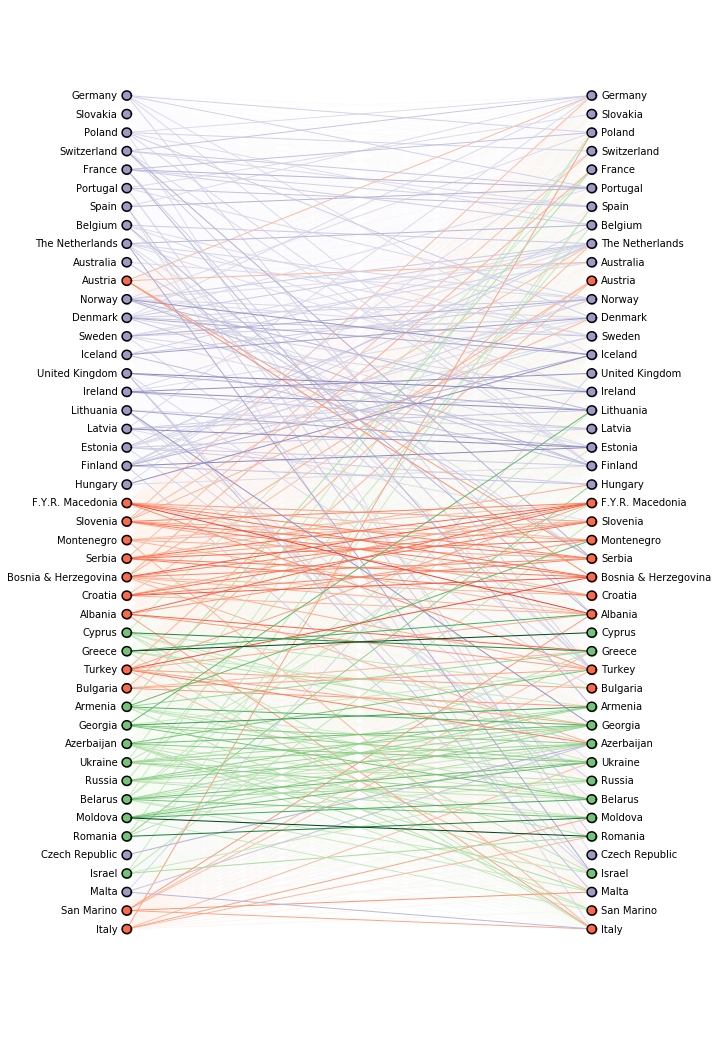

In [70]:
# Reorder the countries so that the clusters are easier to see
country_order = [
    'Italy',
    'San Marino',
    'Malta',
    'Israel',
    'Czech Republic',
    'Romania',
    'Moldova',
    'Belarus',
    'Russia',
    'Ukraine',
    'Azerbaijan',
    'Georgia',
    'Armenia',
    'Bulgaria',
    'Turkey',
    'Greece',
    'Cyprus',
    'Albania',
    'Croatia',
    'Bosnia & Herzegovina',
    'Serbia',
    'Montenegro',
    'Slovenia',
    'F.Y.R. Macedonia',
    'Hungary',
    'Finland',
    'Estonia',
    'Latvia',
    'Lithuania',
    'Ireland',
    'United Kingdom',
    'Iceland',
    'Sweden',
    'Denmark',
    'Norway',
    'Austria',
    'Australia',
    'The Netherlands',
    'Belgium',
    'Spain',
    'Portugal',
    'France',
    'Switzerland',
    'Poland',
    'Slovakia',
    'Germany'
    ]

remap = np.argsort([countries_map[country] for country in country_order])
# draw.bipartite_graph(np.exp(phi_df) * (phi_df > 2.0), clusters, remap, 1.0, 1.0, 0.5)
draw.bipartite_graph(phi_df * (phi_df > 0.026), clusters, remap, 1.0, 1.0, 0.5)
plt.savefig('images/bipartite_graph.png', bbox_inches='tight', dpi=150)

# Maps

In [71]:
# Download the file:
# https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip
# and place the contents of the zip in the data folder.

import geopandas as gpd

country_codes = pd.read_csv(full_path('country_codes.csv'))

shapefile = full_path('ne_10m_admin_0_countries.shp')
shape = gpd.read_file(shapefile)
gdf = shape.to_crs("+init=epsg:3035")
gdf_australia = shape.to_crs("+init=epsg:3577")

clusters_df = pd.DataFrame(
    {
        'Country': countries,
        'cluster': clusters,
        'strength': cluster_strengths
    }
)

def merge_with_map(map_df, country_codes):
    """Adds full country names to country codes. Also adjusts some country names."""
    return (
        pd.merge(map_df, country_codes)
        .replace({'Russian Federation': 'Russia',
                  'Netherlands': 'The Netherlands',
                  'Czechia': 'Czech Republic',
                  'Bosnia and Herzegovina': 'Bosnia & Herzegovina',
                  'Moldova, Republic of': 'Moldova',
                  'Macedonia, the former Yugoslav Republic of': 'F.Y.R. Macedonia'})
    )

eurovision_map = merge_with_map(gdf, country_codes)

eurovision_map_australia = merge_with_map(gdf_australia, country_codes)

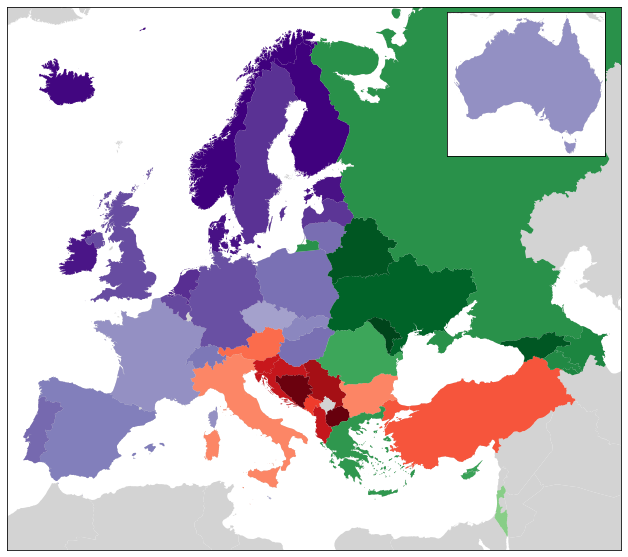

In [72]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, figsize=(11, 10))
f.subplots_adjust(hspace=0.0, wspace=0.0)
gdf.plot(ax=ax, color='lightgrey')

eurovision_map_cluster = pd.merge(eurovision_map, clusters_df, left_on='Country name', right_on='Country')

eurovision_map_cluster[eurovision_map_cluster['cluster'] == 0].plot(ax=ax,
                                                                    cmap='Reds',
                                                                    vmin=-0.05,
                                                                    column='strength')
eurovision_map_cluster[eurovision_map_cluster['cluster'] == 1].plot(ax=ax,
                                                                    cmap='Purples',
                                                                    vmin=-0.05,
                                                                    column='strength')
eurovision_map_australia_cluster = pd.merge(eurovision_map_australia, clusters_df, left_on='Country name', right_on='Country')
inset_ax = inset_axes(ax, 
                      width=1.5*(2.5/1.5),
                      height=1.2*(2.5/1.5),
                      loc=1)
gdf_australia.plot(ax=inset_ax, color='lightgrey')
eurovision_map_australia_cluster.plot(ax=inset_ax,
                                      cmap='Purples',
                                      vmin=-0.05,
                                      column='strength')
inset_ax.set_xlim(-0.21e7, 0.22e7)
inset_ax.set_ylim(-0.49e7, -0.1e7)
inset_ax.axes.get_xaxis().set_visible(False)
inset_ax.axes.get_yaxis().set_visible(False)

eurovision_map_cluster[eurovision_map_cluster['cluster'] == 2].plot(ax=ax,
                                                                    cmap='Greens',
                                                                    vmin=-0.05,
                                                                    column='strength')
ax.set_xlim(0.25e7, 0.77e7)
ax.set_ylim(0.10e7, 0.56e7)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.savefig('images/clusters_map.png', bbox_inches='tight', dpi=150)

# Unbiased results

Now let's explore the unbiased results, and comparing them with the actuals. Did the right song win? According to our model, yes it did!

In [ ]:
years = []
first = []
second = []
third = []
fourth = []

for year in range(2010, 2016):
    sorted_results = sorted([(country, theta_mean[countries_map[country], years_map[year]])
                             for country in countries],
                             key=lambda _:_[1])[::-1]
    years.append(year)
    first.append(sorted_results[0][0])
    second.append(sorted_results[1][0])
    third.append(sorted_results[2][0])
    fourth.append(sorted_results[3][0])

unbiased_results = pd.DataFrame(
    {
        'Winner': first,
        'Runner-up': second,
        'Third': third,
        'Fourth': fourth
    },
    index=pd.Index([f'{year} unbiased' for year in years], name='Year')
).transpose()

In [ ]:
actual_results = pd.concat([
    (
        eurovision[(eurovision['Year'] == year) & (eurovision['Stage'] == 'f')][['To country', 'Points']]
        .groupby('To country')
        .agg(sum)
        .sort_values('Points', ascending=False)
        .reset_index()
        .iloc[0:5, :]
        .assign(s=lambda _: _['To country'] + ' (' + _['Points'].astype(str) + ')')[['s']].transpose()
        .set_index(pd.Index([year], name='Year'))
        .rename(columns={
            0: 'Winner',
            1: 'Runner-up',
            2: 'Third',
            3: 'Fourth',
            4: 'Fifth'
        })
    )
    for year in range(2010, 2016)
]).iloc[:, 0:4].transpose()

In [ ]:
together = pd.concat([actual_results, unbiased_results], axis=1)

In [ ]:
together[[2010, '2010 unbiased']]

In [ ]:
together[[2011, '2011 unbiased']]

In [ ]:
together[[2012, '2012 unbiased']]

In [ ]:
together[[2013, '2013 unbiased']]

In [ ]:
together[[2014, '2014 unbiased']]

In [ ]:
together[[2015, '2015 unbiased']]

# Excluding clusters

Here we explore what *would* have happened if one of our blocks wouldn't be allowed to
vote. Would it affect the end result?

In [ ]:
# Merge eurovision with clusters
c_df = (
    eurovision
    .merge(
        clusters_df
        .rename(columns={'Country': 'From country'})
    )
)

# 0: East
# 1: West
# 2: Balkans

In [ ]:
# No east
pd.concat([
    (
        c_df[(c_df['cluster'] != 0) & (c_df['Year'] == year) & (c_df['Stage'] == 'f')][['To country', 'Points']]
        .groupby('To country')
        .agg(sum)
        .sort_values('Points', ascending=False)
        .reset_index()
        # Take top five
        .iloc[0:5, :]
        .assign(s=lambda _: _['To country'] + ' (' + _['Points'].astype(str) + ')')[['s']].transpose()
        .set_index(pd.Index([year], name='Year'))
        .rename(columns={
            0: 'Winner',
            1: 'Runner-up',
            2: 'Third',
            3: 'Fourth',
            4: 'Fifth'
        })
    )
    for year in range(2010, 2016)
])

In [ ]:
# No west
pd.concat([
    (
        c_df[(c_df['cluster'] != 1) & (c_df['Year'] == year) & (c_df['Stage'] == 'f')][['To country', 'Points']]
        .groupby('To country')
        .agg(sum)
        .sort_values('Points', ascending=False)
        .reset_index()
        .iloc[0:5, :]
        .assign(s=lambda _: _['To country'] + ' (' + _['Points'].astype(str) + ')')[['s']].transpose()
        .set_index(pd.Index([year], name='Year'))
        .rename(columns={
            0: 'Winner',
            1: 'Runner-up',
            2: 'Third',
            3: 'Fourth',
            4: 'Fifth'
        })
    )
    for year in range(2010, 2016)
])

In [ ]:
# No Balkans
pd.concat([
    (
        c_df[(c_df['cluster'] != 2) & (c_df['Year'] == year) & (c_df['Stage'] == 'f')][['To country', 'Points']]
        .groupby('To country')
        .agg(sum)
        .sort_values('Points', ascending=False)
        .reset_index()
        .iloc[0:5, :]
        .assign(s=lambda _: _['To country'] + ' (' + _['Points'].astype(str) + ')')[['s']].transpose()
        .set_index(pd.Index([year], name='Year'))
        .rename(columns={
            0: 'Winner',
            1: 'Runner-up',
            2: 'Third',
            3: 'Fourth',
            4: 'Fifth'
        })
    )
    for year in range(2010, 2016)
])

# Winner's votes

Finally, lets have a look at who voted for the winner and the runner-up. In general there's not much to note, but some years there's pretty clear divisions that can be seen. For example, Serbia got the full backing of the Balkans in 2007, and Finland's win over Russia in 2006 shows a clear east/west divide.

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_to_votes(ax, df, year, country, points):
    """
    Plots a map showing how many points each country gave 'country' in
    the year 'year' in the final.
    """
    to_plot = (
        df[(df['To country'] == country) & (df['Year'] == year) & (df['Stage'] == 'f')][['From country', 'To country', 'Points']]
        .groupby(['From country', 'To country'])
        .sum()
        .reset_index()
    )

    eurovision_map_w = pd.merge(eurovision_map, to_plot, left_on='Country name', right_on='From country')
    
    gdf.plot(ax=ax, color='lightgrey')
    eurovision_map_w.plot(ax=ax,
                          cmap=cmap,
                          column='Points')
    zeros = eurovision_map_w[eurovision_map_w['Points'] == 0]
    if zeros.shape[0] > 0:
        zeros.plot(ax=ax, color=(np.array([107.0, 107.0, 107.0, 255.0]) / 255))

    ax.set_xlim(0.25e7, 0.77e7)
    ax.set_ylim(0.08e7, 0.56e7)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_title(f'{country} {year} ({points})')
    
    if sum(eurovision_map_w['From country'] == 'Australia') > 0:
        eurovision_map_australia_w = pd.merge(eurovision_map_australia, to_plot, left_on='Country name', right_on='From country')
        inset_ax = inset_axes(ax, 
                              width=1.5,
                              height=1.2,
                              loc=1)
        gdf_australia.plot(ax=inset_ax, color='lightgrey')
        eurovision_map_australia_w.plot(ax=inset_ax,
                                        cmap=cmap,
                                        column='Points')
        inset_ax.set_xlim(-0.21e7, 0.22e7)
        inset_ax.set_ylim(-0.49e7, -0.1e7)
        inset_ax.axes.get_xaxis().set_visible(False)
        inset_ax.axes.get_yaxis().set_visible(False)

def plot_winner_and_runner_up(df, year):
    """
    Finds the winner and runner up in year 'year', and plots maps
    showing how many points they recieved from other countries.
    """
    total_points_ordered = (
        df[(df['Year'] == year) & (df['Stage'] == 'f')][['To country', 'Points']]
        .groupby('To country')
        .sum()
        .sort_values(by='Points', ascending=False)
    )
    
    winner = total_points_ordered.index[0]
    winner_pts = total_points_ordered.iloc[0]['Points']
    runner_up = total_points_ordered.index[1]
    runner_up_pts = total_points_ordered.iloc[1]['Points']
    
    ratio = 15/6.5
    width = 15
    dpi=75
    f, ax = plt.subplots(1, 2, figsize=(width, width/ratio)) # f, ax = plt.subplots(1, figsize=(10, 10))
    plot_to_votes(ax[0], df, year, winner, winner_pts)
    plot_to_votes(ax[1], df, year, runner_up, runner_up_pts)

for year in range(2001, 2019):
    plot_winner_and_runner_up(eurovision, year)

# Reproducing results using the model

In [ ]:
hist(extract['theta'][:, countries_map['Sweden'], years_map[2015]], 100, alpha=0.5, color=cmap(0.0))
hist(extract['theta'][:, countries_map['Russia'], years_map[2015]], 100, alpha=0.5, color=cmap(1.0))
plt.savefig('images/sweden-russia.png', bbox_inches='tight', dpi=150)

In [ ]:
sweden = np.random.choice(extract['theta'][:, countries_map['Sweden'], years_map[2015]], 10000)
russia = np.random.choice(extract['theta'][:, countries_map['Russia'], years_map[2015]], 10000)
sum((sweden - russia) >=0) / len(sweden)

In [ ]:
sum((sweden - russia) >=0) / len(sweden)

In [ ]:
(
    extract['theta'][:, countries_map['Sweden'], years_map[2015]]
    > extract['theta'][:, countries_map['Russia'], years_map[2015]]
).mean()

In [ ]:
from matplotlib.colors import LogNorm
x = extract['theta'][:, countries_map['Sweden'], years_map[2015]]
y = extract['theta'][:, countries_map['Russia'], years_map[2015]]
plt.figure(figsize=(10, 10))
plt.hist2d(x,
           y,
           bins=100,
           norm=LogNorm(),
           cmap=cmap.reversed())
xmean = x.mean()
ymean = y.mean()
xwidth = max(x.mean() - x.min(), x.max() - x.mean())
ywidth = max(y.mean() - y.min(), y.max() - y.mean())
buffer = 1.1
xmin = xmean - buffer * xwidth
xmax = xmean + buffer * xwidth
ymin = ymean - buffer * ywidth
ymax = ymean + buffer * ywidth
lmin = min(xmin, ymin)
lmax = max(xmax, ymax)

labelsize = 18

plt.plot([lmin, lmax], [lmin, lmax], color=cmap(0.5))
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.xlabel('Sweden (2015)', fontsize=labelsize)
plt.ylabel('Russia (2015)', fontsize=labelsize)
plt.savefig('images/sweden-russia-hist2d.png', bbox_inches='tight', dpi=150)

In [ ]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(10, 10))
plt.hist2d(np.random.choice(extract['theta'][:, countries_map['Sweden'], years_map[2015]], 16000),
           np.random.choice(extract['theta'][:, countries_map['Russia'], years_map[2015]], 16000),
           bins=100,
           norm=LogNorm())
plt.plot([1, 2], [1, 2])
plt.xlim([1, 2])
plt.ylim([1, 2])

In [ ]:
np.cov(10*np.random.choice(extract['theta'][:, countries_map['Sweden'], years_map[2015]], 16000),
       10*np.random.choice(extract['theta'][:, countries_map['Russia'], years_map[2015]], 16000))

In [ ]:
extract['theta'][:, countries_map['Sweden'], years_map[2015]].mean()

In [ ]:
extract['theta'][:, countries_map['Russia'], years_map[2015]].mean()

In [ ]:
cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Data Mettle Blue With Wite',
    [(1.0, 1.0, 1.0), (0.28205128, 0.87179487, 1.0), (0.09401709, 0.29059829, 0.33333333)]
)

# Possibly fudge phi_df to make patterns more visible
phi_coarse = phi_df / phi_df.sum()
heatmap = np.zeros((len(country_order), len(country_order)))
for i, from_country in enumerate(country_order):
    for j, to_country in enumerate(country_order):
        value = phi_coarse.iat[i, j]
        heatmap[i, j] = value

fix, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(heatmap, cmap=cmap2)

# We want to show all ticks...
ax.set_xticks(np.arange(len(country_order)))
ax.set_yticks(np.arange(len(country_order)))
# ... and label them with the respective list entries
ax.set_xticklabels(country_order)
ax.set_yticklabels(country_order)

# Rotate the tick labels and set their alignment.
_ = plt.setp(ax.get_xticklabels(), rotation=90, ha="right", va="center",
             rotation_mode="anchor")
